# Cointegration Analysis of Stock Pairs

This notebook investigates potential cointegration between selected stock pairs using historical price data from `yfinance`. Cointegration refers to a long-term equilibrium relationship between two non-stationary time series, commonly exploited in statistical arbitrage and pair trading strategies.

---

## Methodology

We utilize the **Augmented Dickey-Fuller (ADF) test** to examine the stationarity of the residuals obtained from an OLS regression of one stock on another. If the residuals are stationary, it suggests the existence of a cointegrated relationship.

Mathematically:

- For stock prices \(X_t\) and \(Y_t\), we fit a model:  
  \[
  Y_t = \alpha + \beta X_t + \epsilon_t
  \]
- We then apply the ADF test on the residuals \(\epsilon_t\) to evaluate:
  \[
  H_0: \text{Residuals are non-stationary} \quad \text{vs} \quad H_1: \text{Residuals are stationary}
  \]

---

## Instructions

Please enter two stock tickers below (e.g., `TSLA` and `NVDA`) in the input fields provided. Click **Run Test** to initiate the cointegration analysis.

The results will display the regression parameters, ADF test statistics, and the p-value for statistical significance.

In [68]:
import ipywidgets as widgets
from IPython.display import display, clear_output
tickers = []
tickers_input = widgets.Text(
    value='',
    description='Tickers',
    placeholder='e.g., AAPL, MSFT',
)
add_ticker_button = widgets.Button(description="Add Ticker")
tickers_display = widgets.Text(
    Value ='',
    description='Tickers:',
    disabled = True,
    layout=widgets.Layout(width='30%')
)

def add_ticker(button):
    ticker = tickers_input.value.strip()
    if ticker and ticker not in tickers:
        tickers.append(ticker)
        tickers_input.value = ''
        tickers_display.value = ', '.join(tickers)

add_ticker_button.on_click(add_ticker)
display(tickers_input, add_ticker_button, tickers_display)


Text(value='', description='Tickers', placeholder='e.g., AAPL, MSFT')

Button(description='Add Ticker', style=ButtonStyle())

Text(value='', description='Tickers:', disabled=True, layout=Layout(width='30%'))

C:\Users\tsego\AppData\Local\Temp\ipykernel_21692\687448129.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period = "3y",)['Close']
[*********************100%***********************]  6 of 6 completed


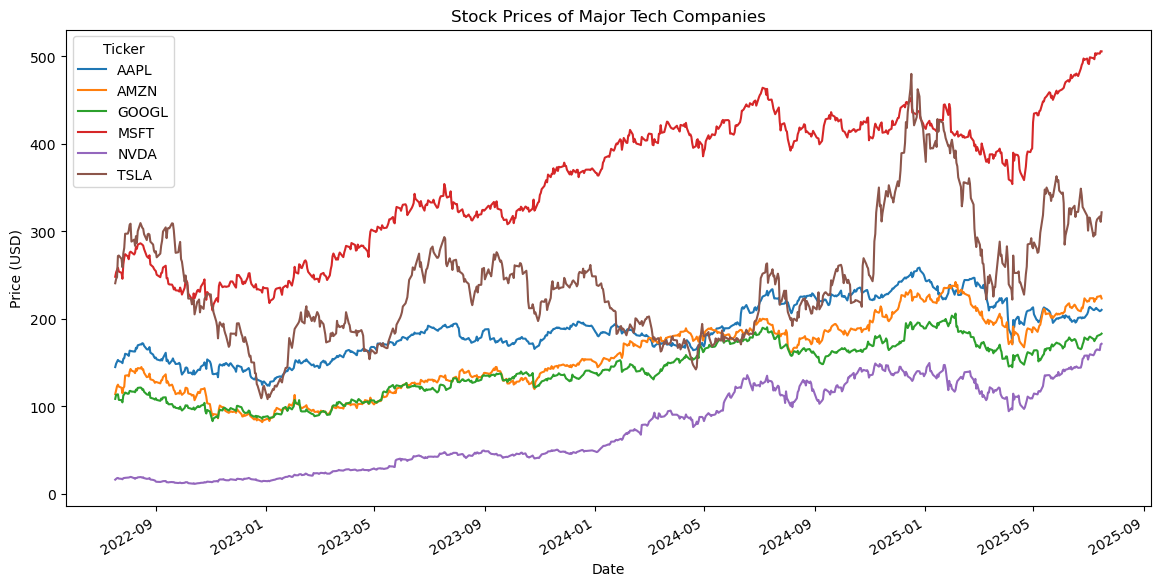

In [69]:
import yfinance as yf
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

# We will start out by defining the ticker symbols for the stocks we want to analyze.
# The following code downloads the historical stock prices for a set of major tech companies over the last three years and plots their closing prices.
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'NVDA']
data = yf.download(tickers, period = "3y",)['Close']
data.plot(figsize=(14, 7))
plt.title('Stock Prices of Major Tech Companies')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.show()

In [70]:
from statsmodels.tsa.stattools import adfuller, coint
import pandas as pd
# Create an empty DataFrame with tickers as both rows and columns
pval_matrix = pd.DataFrame(index=tickers, columns=tickers, dtype=float)

# Fill the matrix with p-values from cointegration tests
for i in range(len(tickers)):
    for j in range(len(tickers)):
        if i != j:
            stock1 = data[tickers[i]]
            stock2 = data[tickers[j]]
            _, pval, _ = coint(stock1, stock2)
            pval_matrix.iloc[i, j] = round(pval, 4)  # rounded for readability
        else:
            pval_matrix.iloc[i, j] = None # No self-cointegration

# Display the p-value matrix
display(pval_matrix)

,AAPL,MSFT,GOOGL,AMZN,TSLA,NVDA
AAPL,NaN,0.7215,0.0606,0.1846,0.3880,0.3433
MSFT,0.9196,NaN,0.2558,0.5233,0.9192,0.2968
GOOGL,0.1157,0.1846,NaN,0.0120,0.7236,0.0670
AMZN,0.3861,0.4787,0.0158,NaN,0.7759,0.1419
TSLA,0.3749,0.4918,0.4395,0.3663,NaN,0.4182
NVDA,0.7535,0.4499,0.1257,0.1769,0.9067,NaN


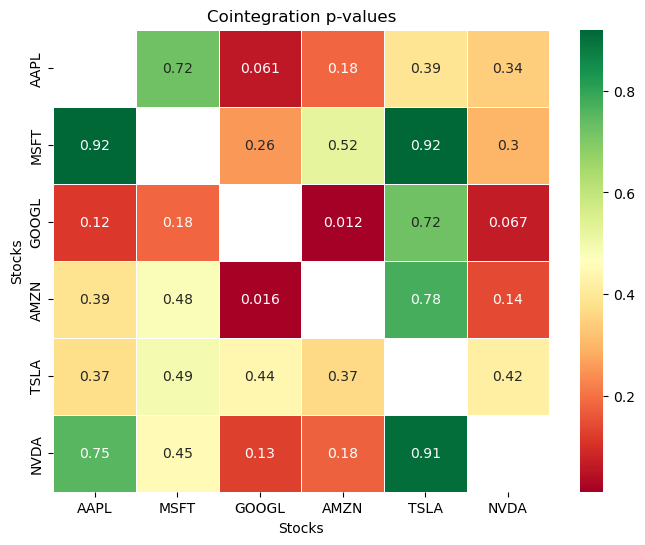

In [75]:
# We can better visualize the cointegration relationships by plotting the the p-value in a heatma.
# The heatmap shows the p-values for the cointegration tests between each pair of stocks.
# A lower p-value indicates a stronger evidence of cointegration.
plt.figure(figsize=(8,6))
sns.heatmap(pval_matrix, annot=True, cmap="RdYlGn", linewidths=.5)
plt.title("Cointegration p-values")
plt.xlabel("Stocks")
plt.ylabel("Stocks")
plt.show()